🔐 Machine Learning and Security
===
**Using URL Composition to Predict Phishing Attempts**

Report and Project by Ray Zapata<br>
July 12, 2021

<br>
<img src='assets/header.jpg'>

### 💠 Project Summary

One of the biggest internal problems with any company relying on electronic communications is employees falling victim to phishing schemes to obtain private, personal, and sensitive information. These attempts make every individual in the workforce a potential vector for information leaks that would result in server failures, customer data compromise, and operation security breaches. 

#### Goals

The goal of this project is to create a classification model that is capable of maximizing the capture of phishing attempts utilizing only the composition of a Universal Resource Locator (URL), also known colloquially as a _web address_, while minimizing instances of false negatives that may result in productivity loss.

#### Initial Hypotheses

Throughout the initial phases of this project, the working hypothesis was that the length in characters and the count of special characters, such as dots `.` and hyphens `-`, would be a strong use in phishing predictions. Anecdotal evidence suggests phishing attempts most frequently make use of subdomains and high path levels to mask the underlying hostname as a legitimate source (i.e. `http://https.apple.com.nz/apple-id-password/%amp;2993?dds99kdjf`)

#### Key Findings

There would prove to be some legitimacy to the above hypotheses, as modeling would utilize recommended features that included these special characters as well as the path level. It was also found that by using clustering methodology to create groupings based on the number of dots to the number of dashes showed statistically significant sample means different from the population mean using analysis of variance (ANOVA) testing. 

In modeling, the most successfully train fitted model was a random forest model that produced results which capture nearly $90\%$ of positive class for the target `is_phishing_attempt`. This model maintained an above $78\%$ overall accuracy throughout creation, evaluation, and testing. 

#### Next Phases

With additional time, it would be worthwhile to use analysis of the web page HTML to find any frequent elements common among illegitimate links. For the purpose of internal security, in actual application a machine dedicate to rendering the pages in question would be the best course of action to prevent shadow installation of common malware or other malicious software.

⏯ Initialize Notebook

In [1]:
# import standard libraries
import pandas as pd
import numpy as np

# import visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import statistical testing
import scipy.stats as stats

# import feature and model algorithms
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import created modules
import prepare as pp
import explore as ex
import model as m

# cosmetic settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('~/.matplotlib/gruvbox.mplstyle')
from end import end

## 💠 Data Acquisition
---

The data utilized throughout this project was acquired from [Kaggle](https://www.kaggle.com/shashwatwork/phishing-dataset-for-machine-learning). This data was collected by [_Choon Lin Tan_](https://data.mendeley.com/datasets/h3cgnj8hft/1) and prepared for machine learning by Kaggle user _Shashwat Tiwari_.

The data has been prepared in a manner that makes significant acquire and preparation unnecessary; however, much of the initial data will be unused to achieve the goals of this project.

In [2]:
# read in CSV to DataFrame
df = pd.read_csv('phishing.csv')

In [3]:
# inspect first two rows
df.head(2)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1


In [4]:
# check .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.0,5000.500000,2886.895680,1.0,2500.750000,5000.500000,7500.250000,10000.0
NumDots,10000.0,2.445100,1.346836,1.0,2.000000,2.000000,3.000000,21.0
SubdomainLevel,10000.0,0.586800,0.751214,0.0,0.000000,1.000000,1.000000,14.0
PathLevel,10000.0,3.300300,1.863241,0.0,2.000000,3.000000,4.000000,18.0
UrlLength,10000.0,70.264100,33.369877,12.0,48.000000,62.000000,84.000000,253.0
NumDash,10000.0,1.818000,3.106258,0.0,0.000000,0.000000,2.000000,55.0
NumDashInHostname,10000.0,0.138900,0.545744,0.0,0.000000,0.000000,0.000000,9.0
AtSymbol,10000.0,0.000300,0.017319,0.0,0.000000,0.000000,0.000000,1.0
TildeSymbol,10000.0,0.013100,0.113709,0.0,0.000000,0.000000,0.000000,1.0
NumUnderscore,10000.0,0.323200,1.114660,0.0,0.000000,0.000000,0.000000,18.0


### 🔥 Acquire Summary

- No null values present in data set
- Column naming scheme obfuscates meaning or is difficult to parse
    - Names will be adjusted to more clearly reflect meaning where needed
- Many variables correspond to HTML elements of web page
    - Focus of initial product is to predict based on data available from URL prior to clicking
    - Non-URL data will be dropped for exploration toward this goal

## 💠 Data Preparation
---

As previously stated, the data acquired for this project is already in a ready state for exploration and modeling. Some of the data is dropped due to serving no purpose in project scope, and columns will be renamed for additional clarity and legibility. The data will then have distributions plotted, and potential outliers dealt with if necessary .

In [6]:
# create variable to hold list of URL specific columns
col_list = [
    'NumDots', 'SubdomainLevel', 'PathLevel',
    'UrlLength', 'NumDash', 'NumDashInHostname',
    'AtSymbol', 'TildeSymbol', 'NumUnderscore',
    'NumPercent', 'NumQueryComponents', 'NumAmpersand',
    'NumHash', 'NumNumericChars',
    'RandomString', 'DomainInSubdomains', 'DomainInPaths',
    'HttpsInHostname', 'HostnameLength', 'PathLength',
    'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords',
    'CLASS_LABEL']

# create dictionary for column name changes
rename_dict = {
    'NumDots':'num_dot_url',
    'SubdomainLevel':'subdomain_level',
    'PathLevel':'path_level',
    'UrlLength':'url_char_length',
    'NumDash':'num_dash_url',
    'NumDashInHostname':'num_dash_hostname',
    'AtSymbol':'has_at_symbol',
    'TildeSymbol':'has_tilde',
    'NumUnderscore':'num_underscore_url',
    'NumQueryComponents':'num_queries',
    'NumAmpersand':'num_ampersand',
    'NumHash':'num_hash',
    'NumNumericChars':'num_numerics',
    'RandomString':'has_random_string',
    'DomainInSubdomains':'domain_in_subdomain',
    'DomainInPaths':'domain_in_path',
    'HttpsInHostname':'https_in_hostname',
    'HostnameLength':'hostname_length',
    'PathLength':'path_length',
    'QueryLength':'query_length',
    'DoubleSlashInPath':'doubleslash_in_path',
    'NumSensitiveWords':'num_sensitive_words',
    'CLASS_LABEL':'is_phishing_attempt'}


In [7]:
# filter to desired columns and rename
df = df[col_list]
df = df.rename(columns=rename_dict)

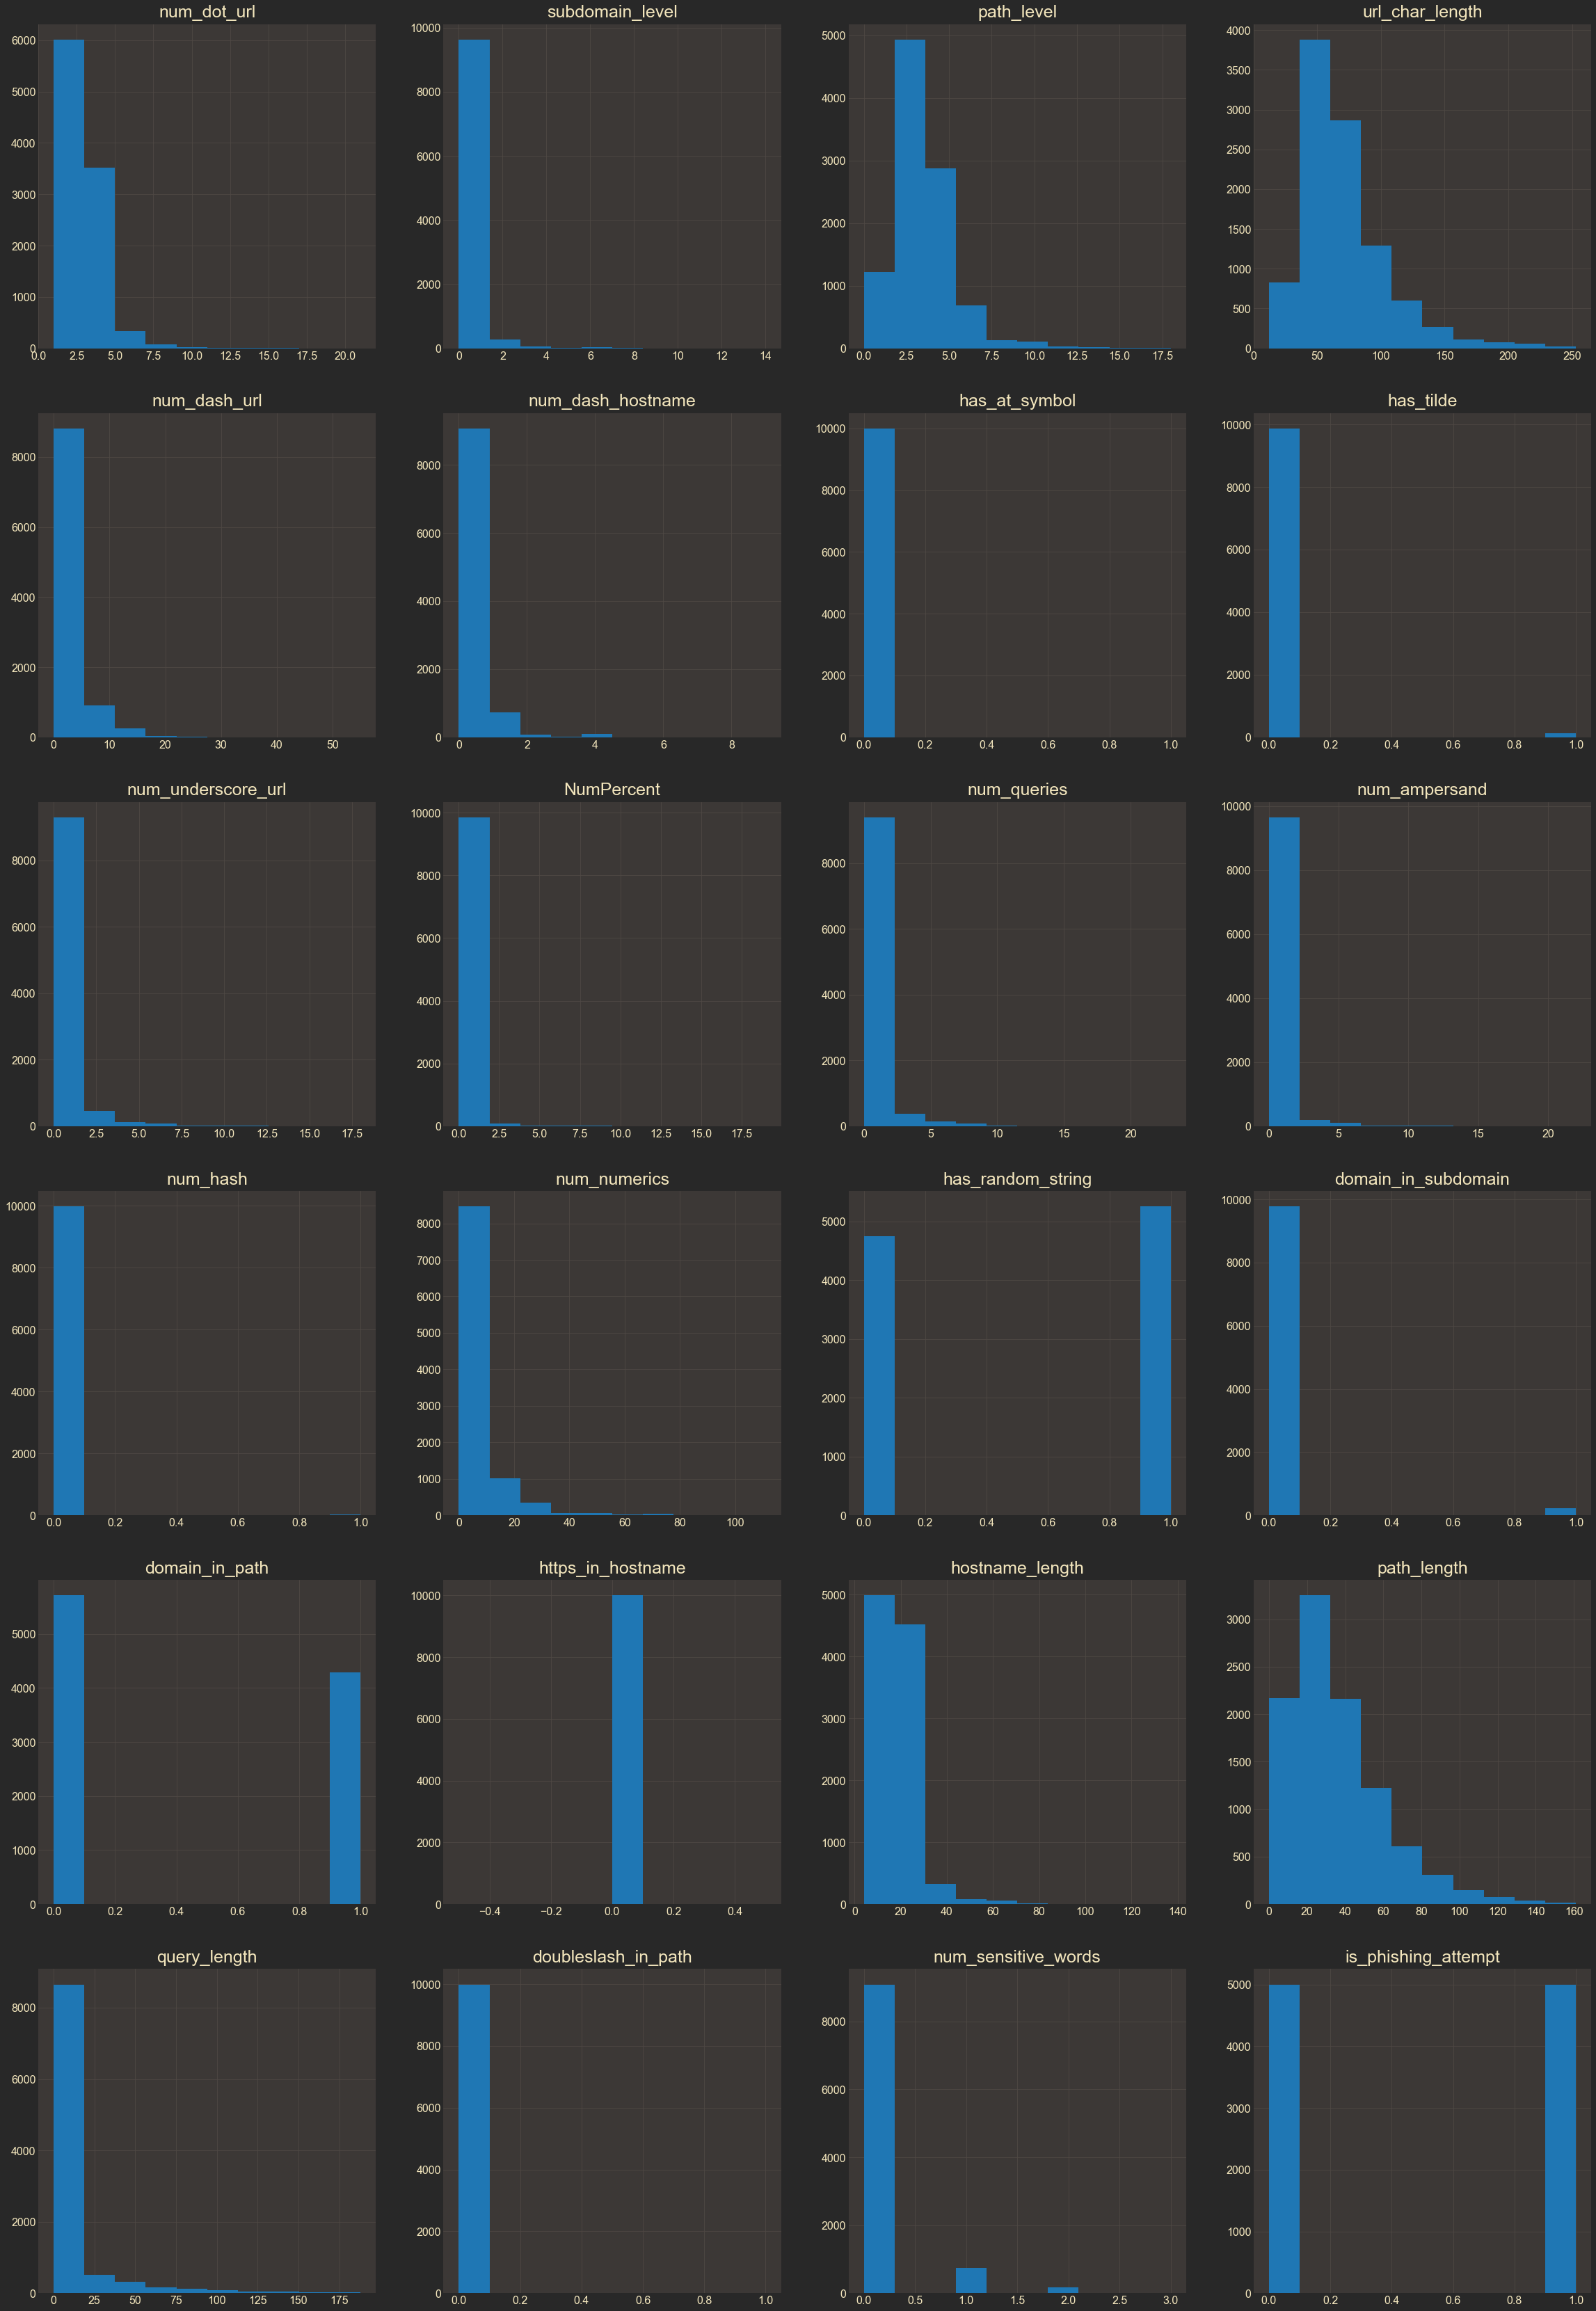

In [8]:
# plot distributions of variables
from math import ceil
nrows = ceil(len(df.columns) / 4)
plt.figure(figsize=(40, nrows * 10))
for n, col in enumerate(df.columns):
    plt.subplot(nrows, 4, n + 1)
    plt.title(f'{df[col].name}', fontsize=25, pad=10)
    plt.hist(df[col])

In [9]:
# check value counts for questionable distributions
df.https_in_hostname.value_counts(), \
df.has_at_symbol.value_counts(), \
df.num_hash.value_counts(), \
df.doubleslash_in_path.value_counts()

(0    10000
 Name: https_in_hostname, dtype: int64,
 0    9997
 1       3
 Name: has_at_symbol, dtype: int64,
 0    9977
 1      23
 Name: num_hash, dtype: int64,
 0    9991
 1       9
 Name: doubleslash_in_path, dtype: int64)

In [10]:
# drop columns that provide insufficent value
df = df.drop(columns=['https_in_hostname', 'has_at_symbol',
                      'num_hash', 'doubleslash_in_path'])

### 🔥 Prepare Summary

- Variable distributions shows some values approaching $100\%$ of the observations in one class over the other(s)
    - These may not offer insights into predicting phishing attempts
- `path_level`, `url_char_length`, and `path_length` are approximately normally distributed
- Most of the `num_` variables and `hostname_length` are strongly right skewed
    - It may be best to maintain these outliers rather than removing them

In [11]:
# split data in advance of exploration
train, validate, test = pp.split_data(df, stratify='is_phishing_attempt')

## 💠 Data Exploration
---

Now that the data is prepared in a consistent manner for the purpose stated in project scope, it can now be explored visually and otherwise. To find strong drivers of phishing attempt URLs, relationship of the variables to each other and the target will be analyzed below.

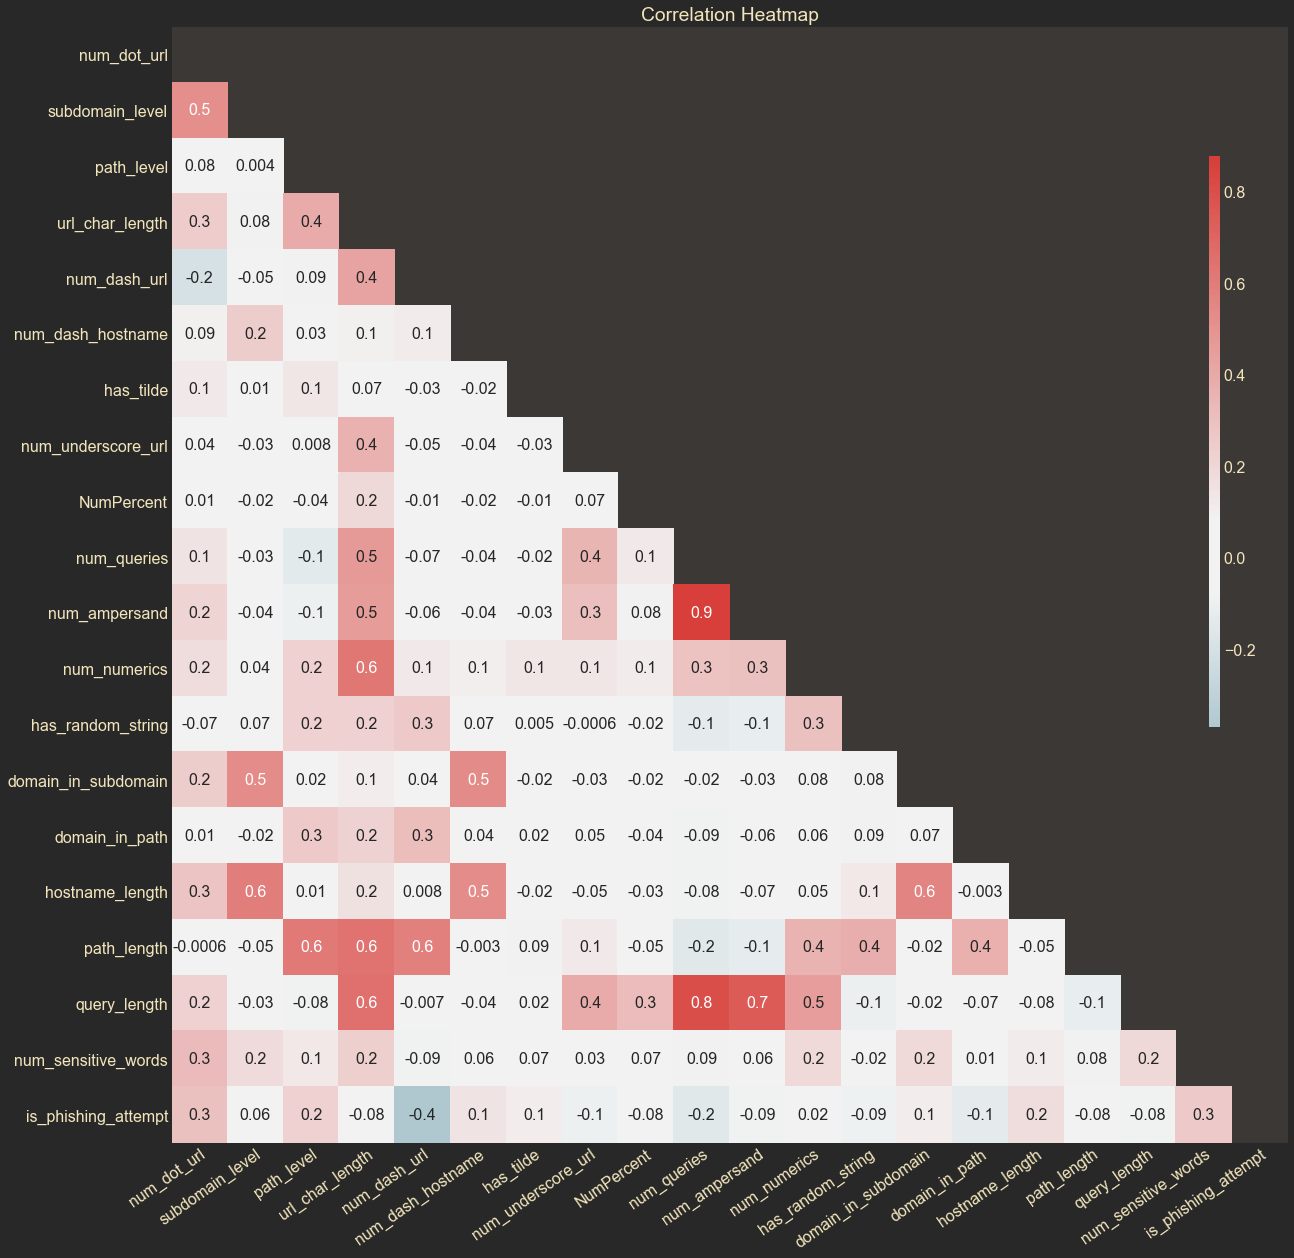

In [12]:
# plot heatmap of variable correlation
ex.plot_heat(train)

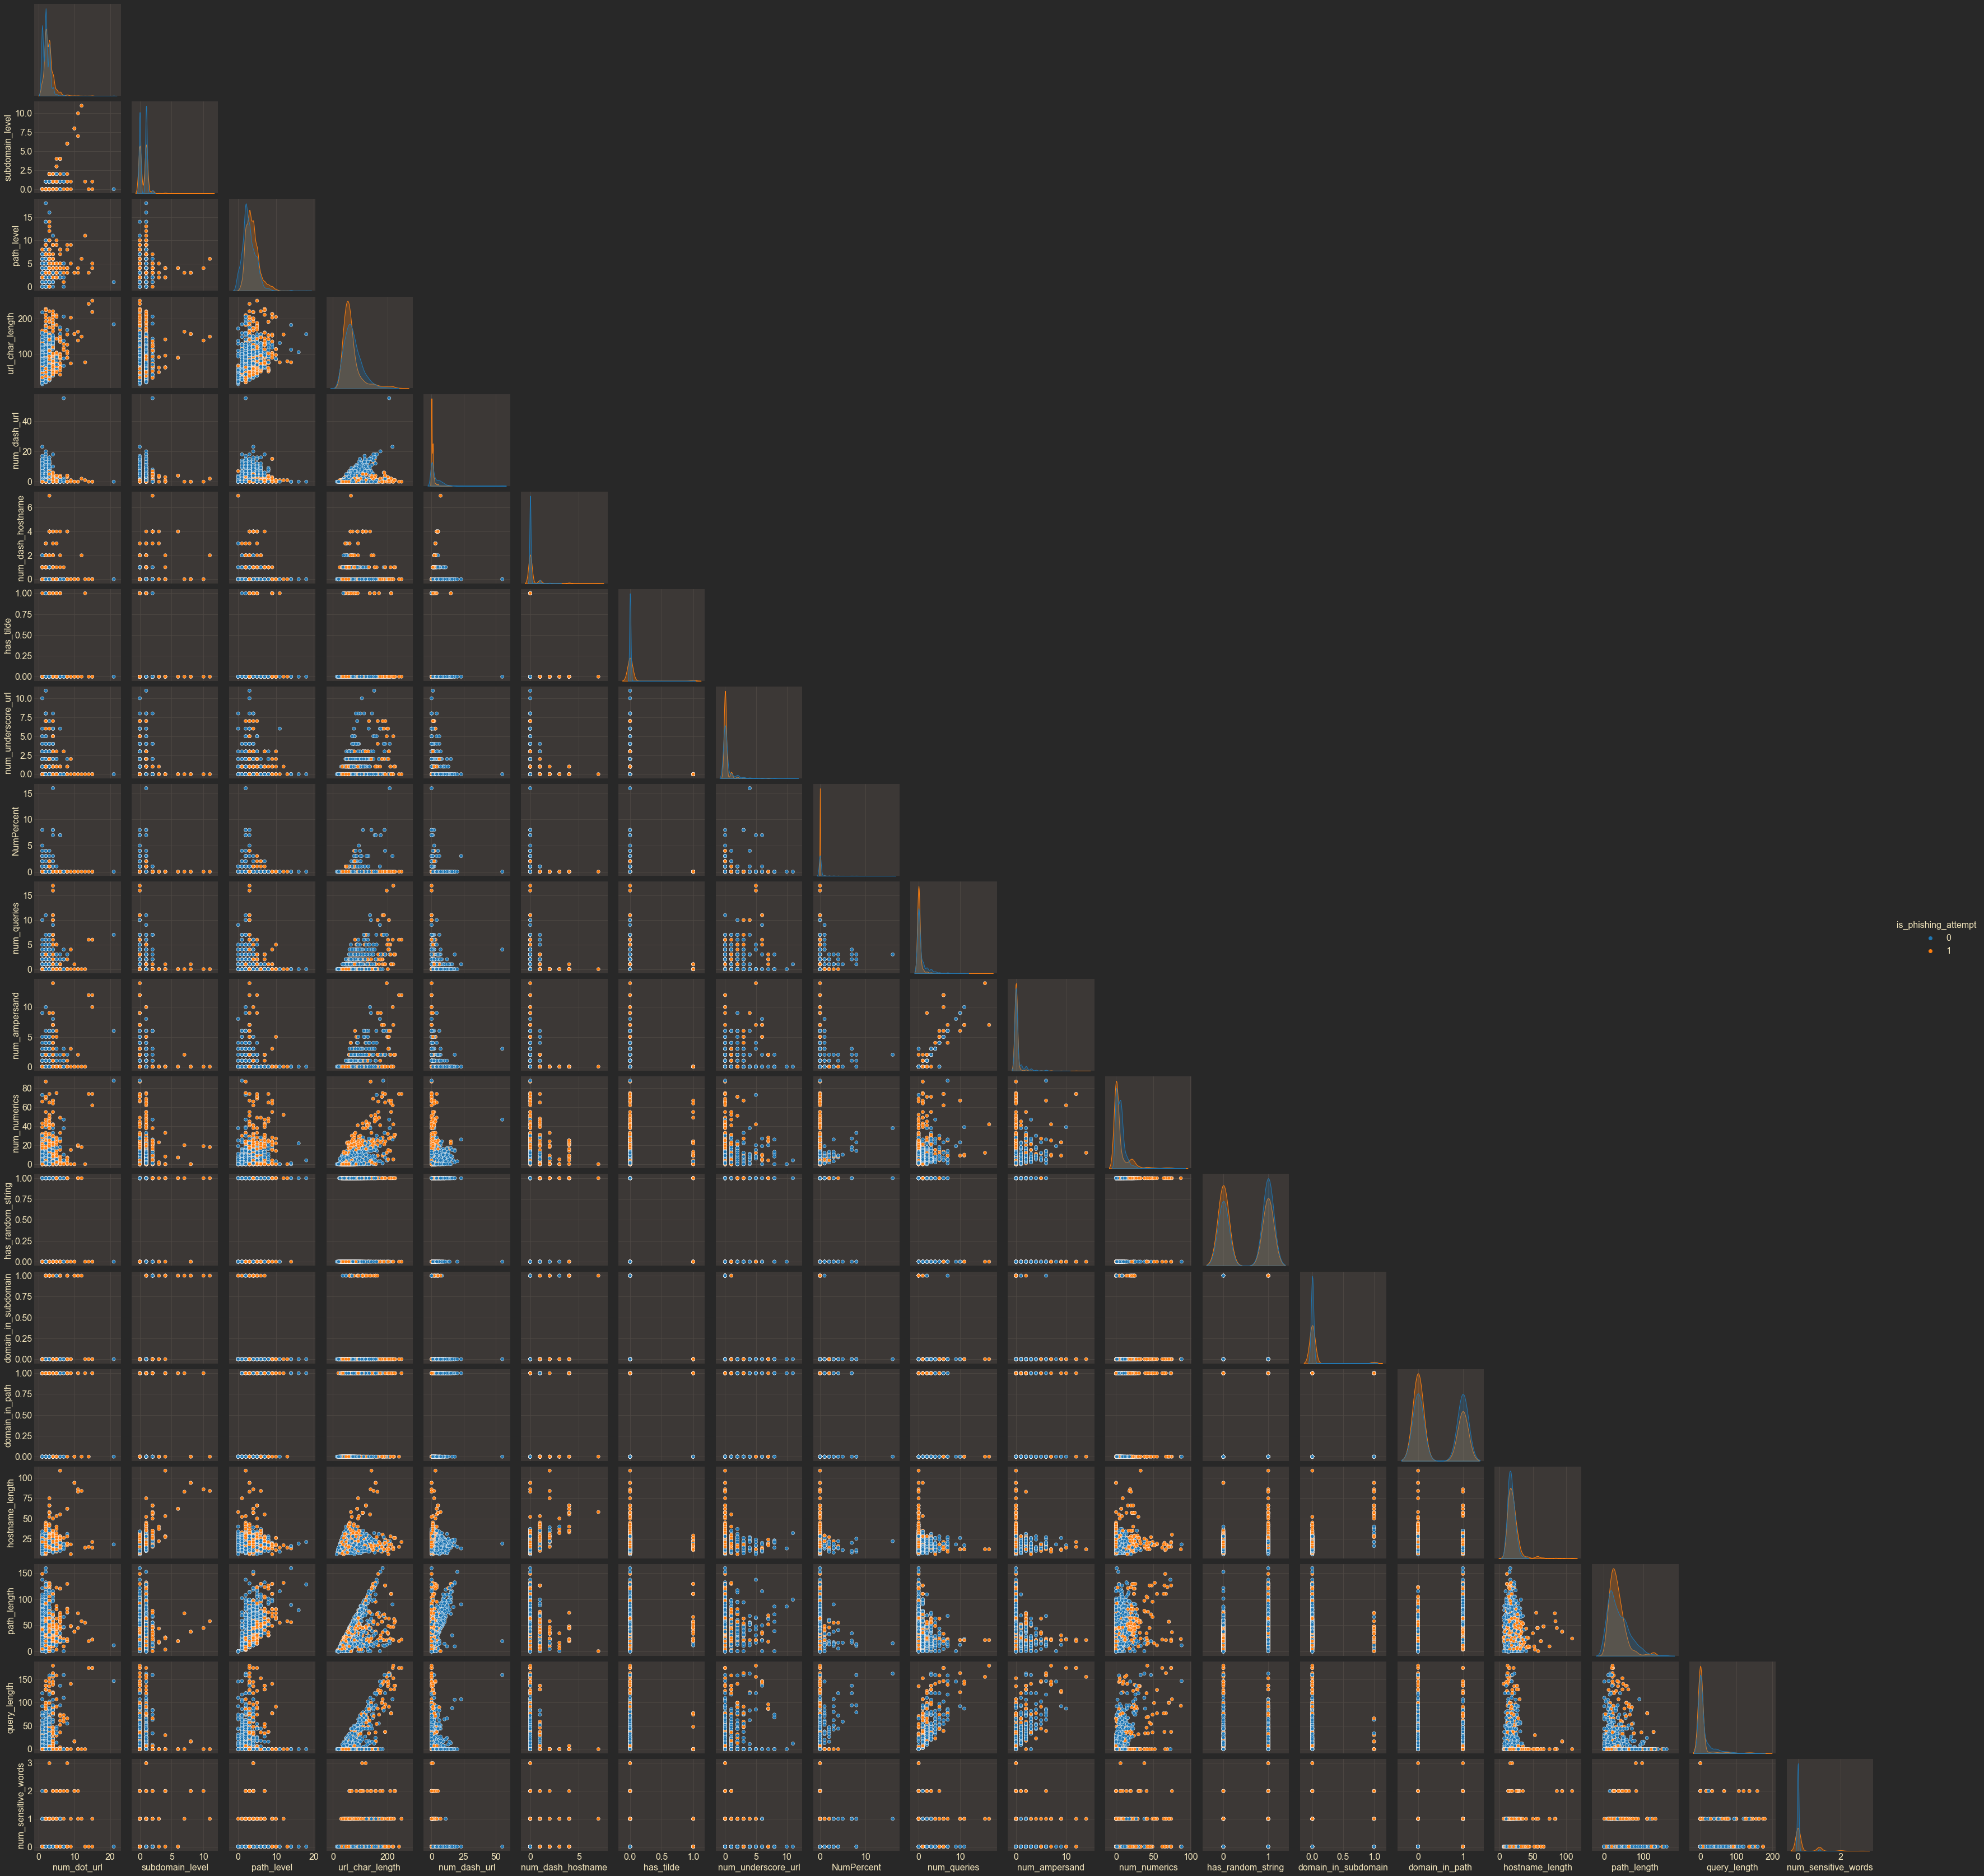

In [13]:
# plot pairplot to find any potential cluster formations
sns.pairplot(train.sample(2000, random_state=19), hue='is_phishing_attempt', corner=True)

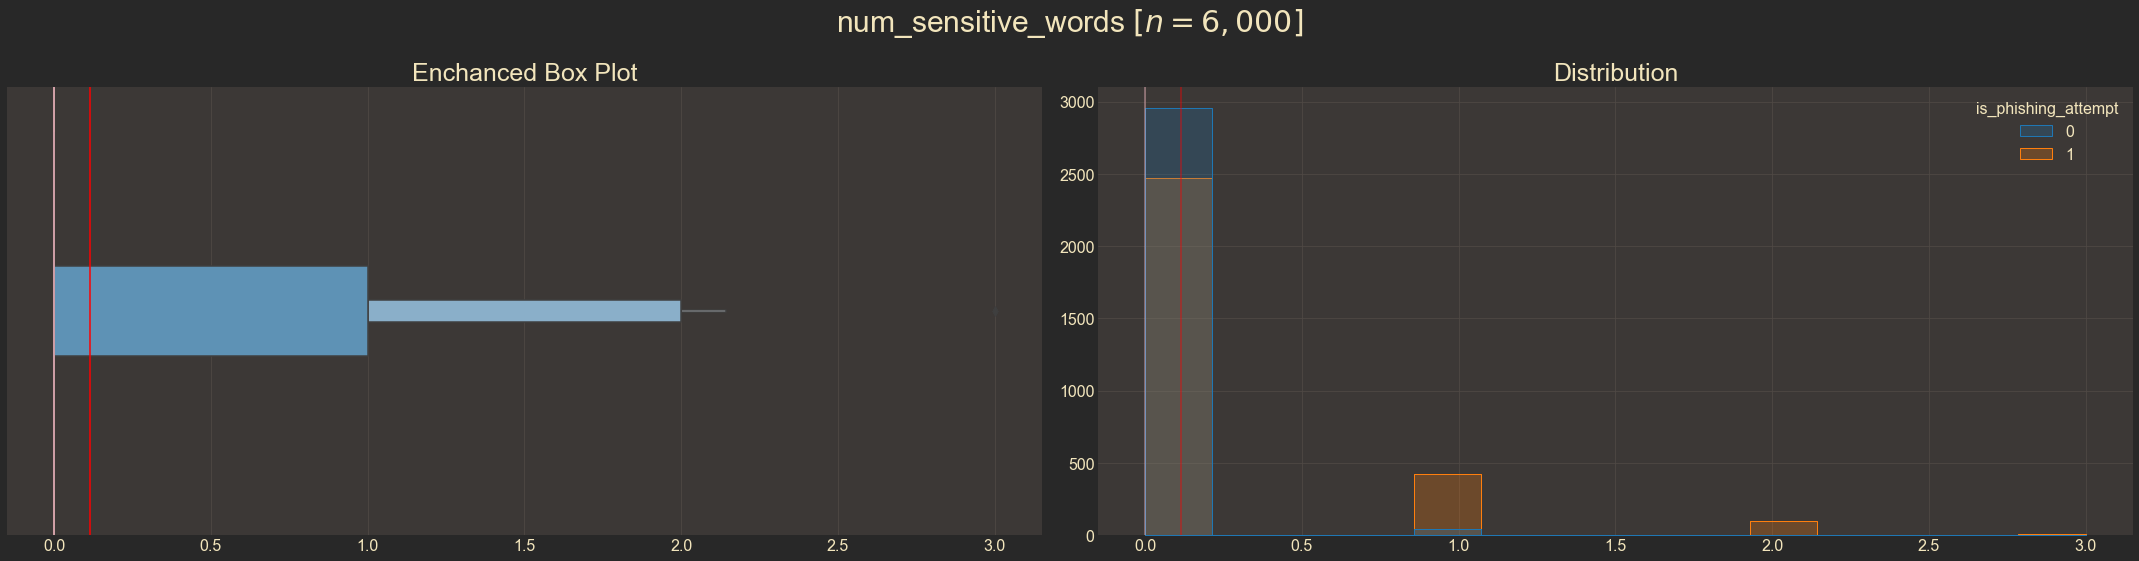

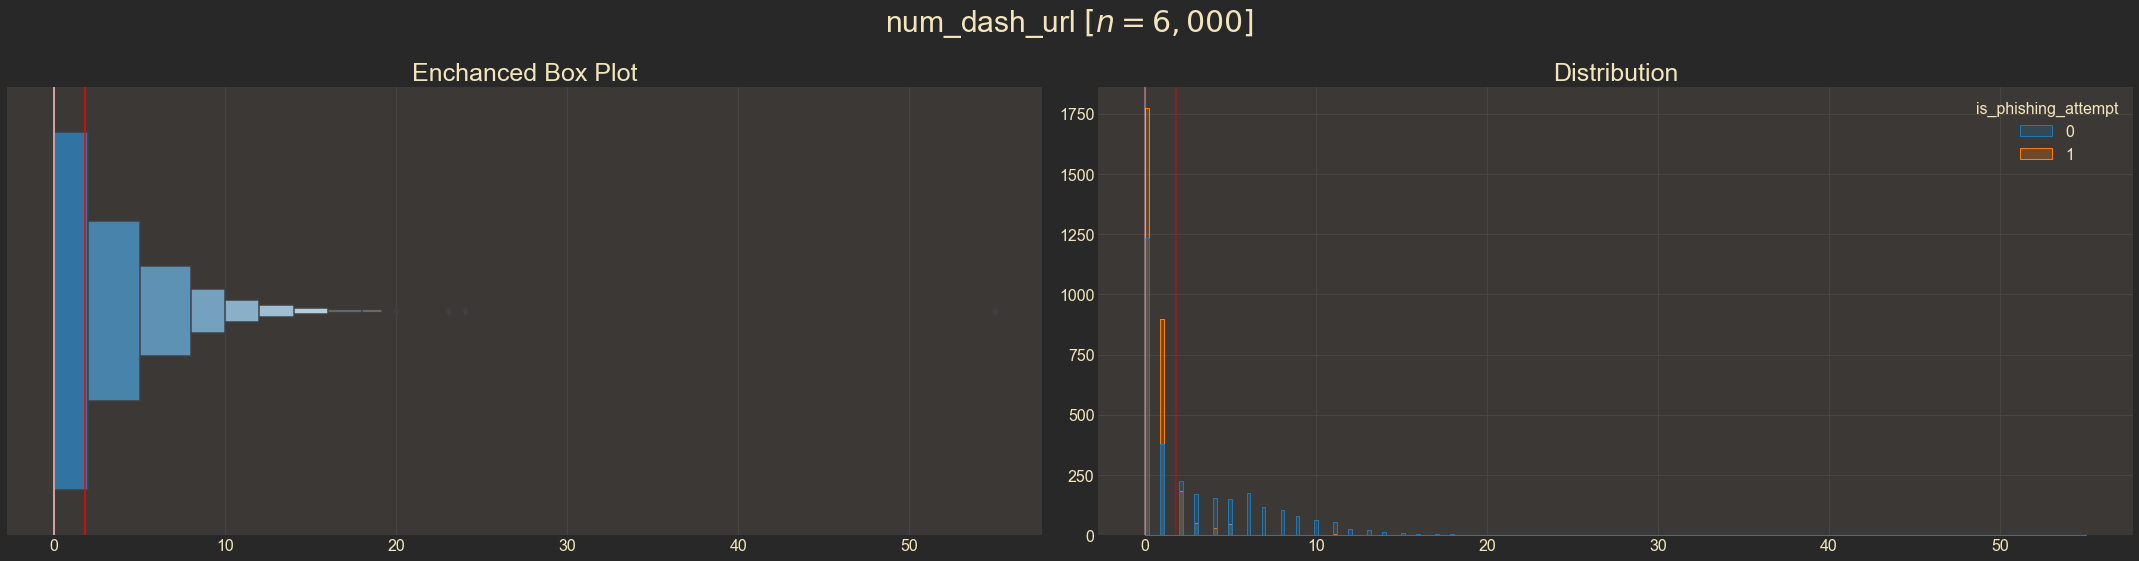

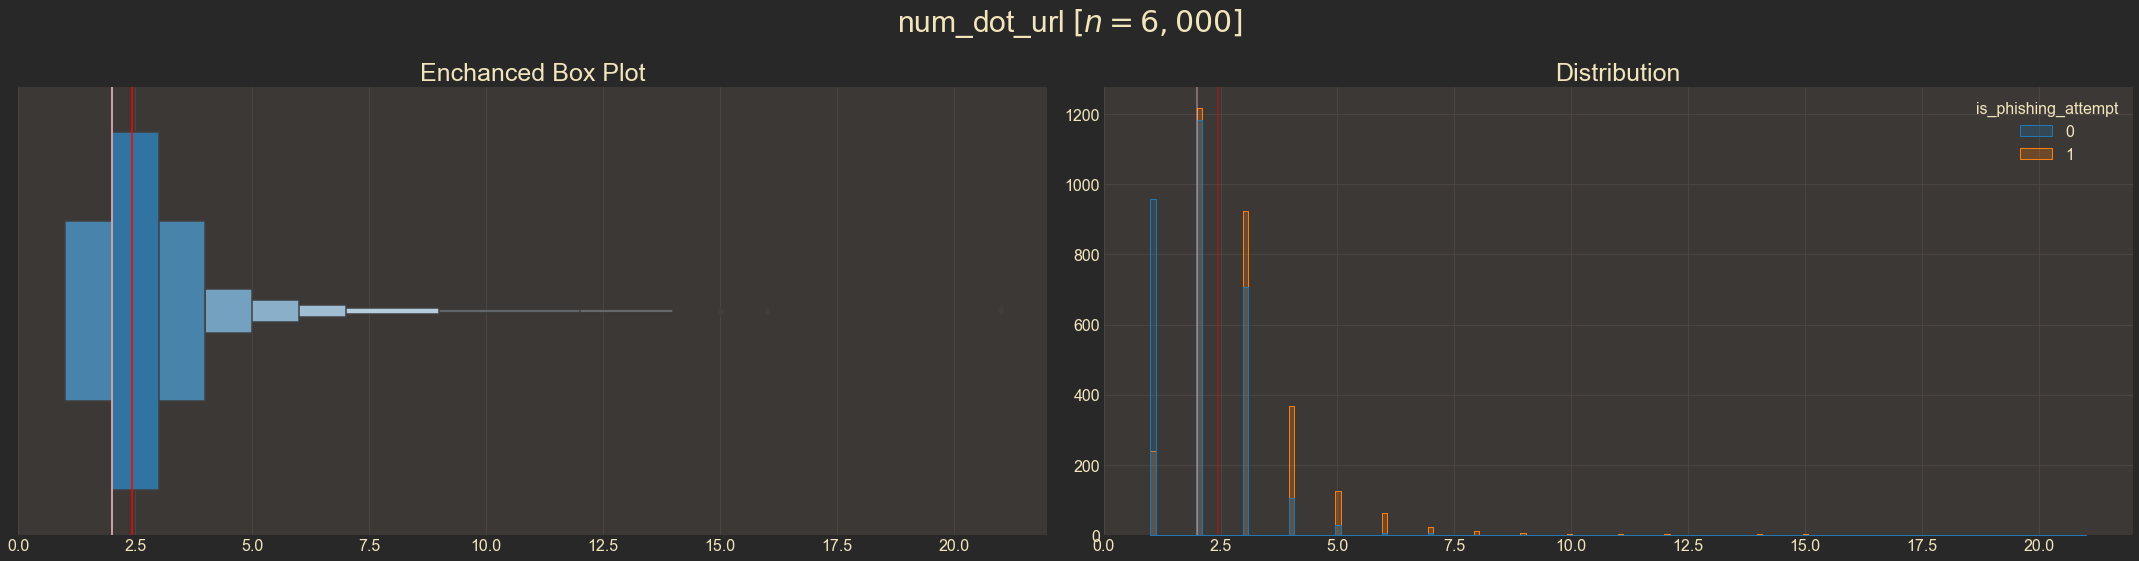

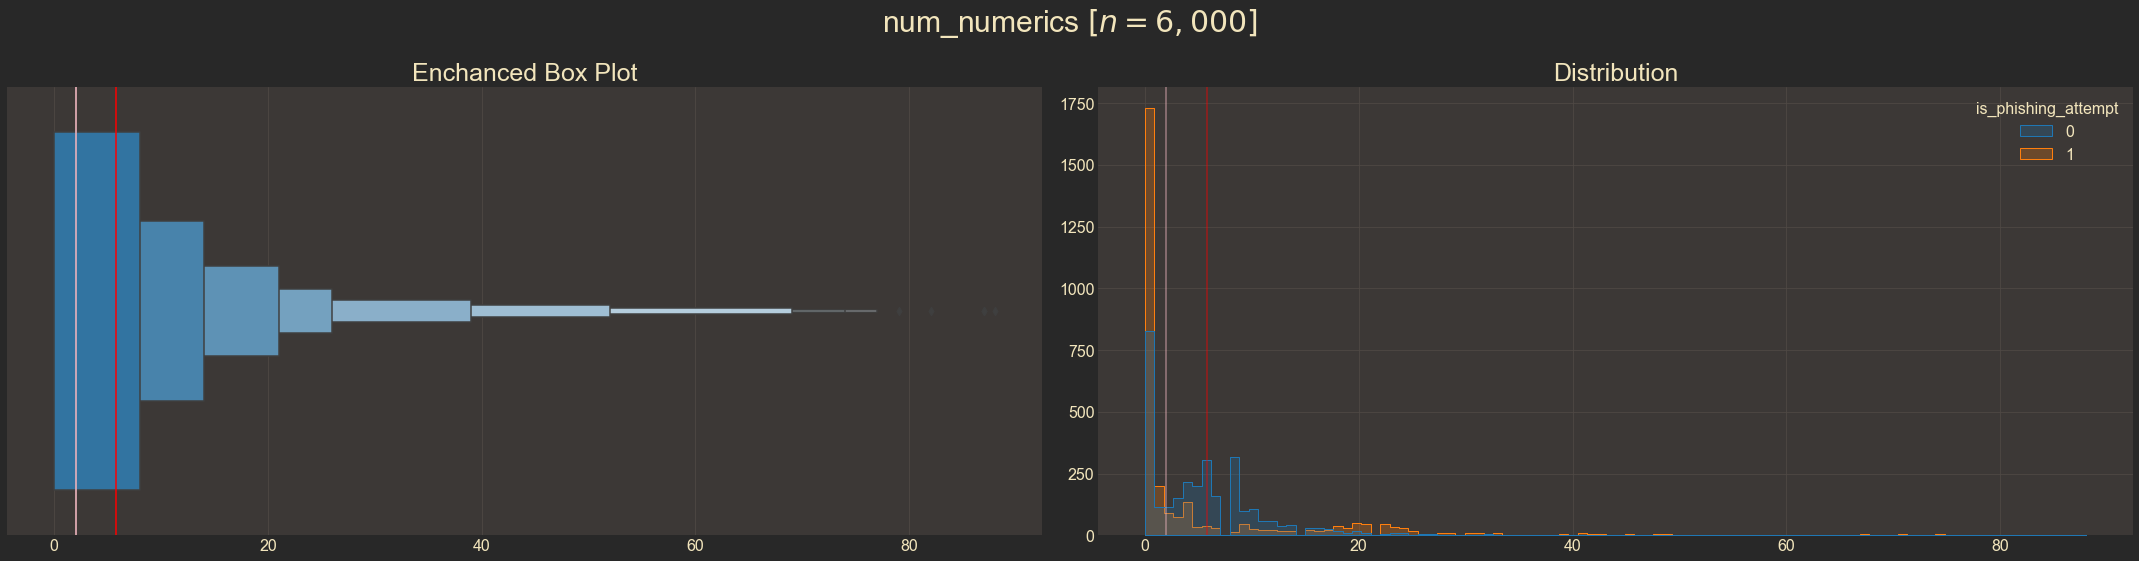

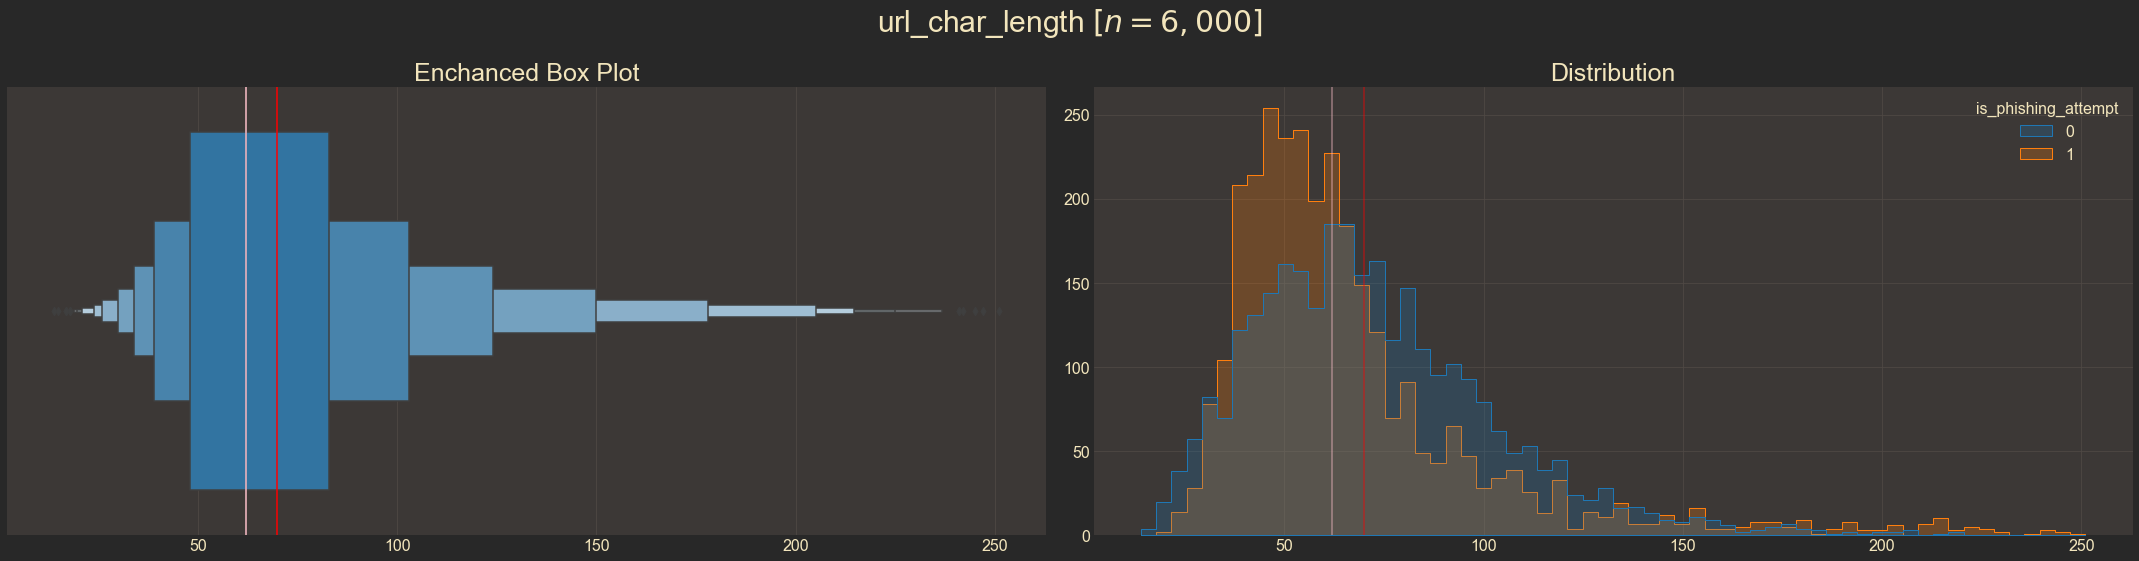

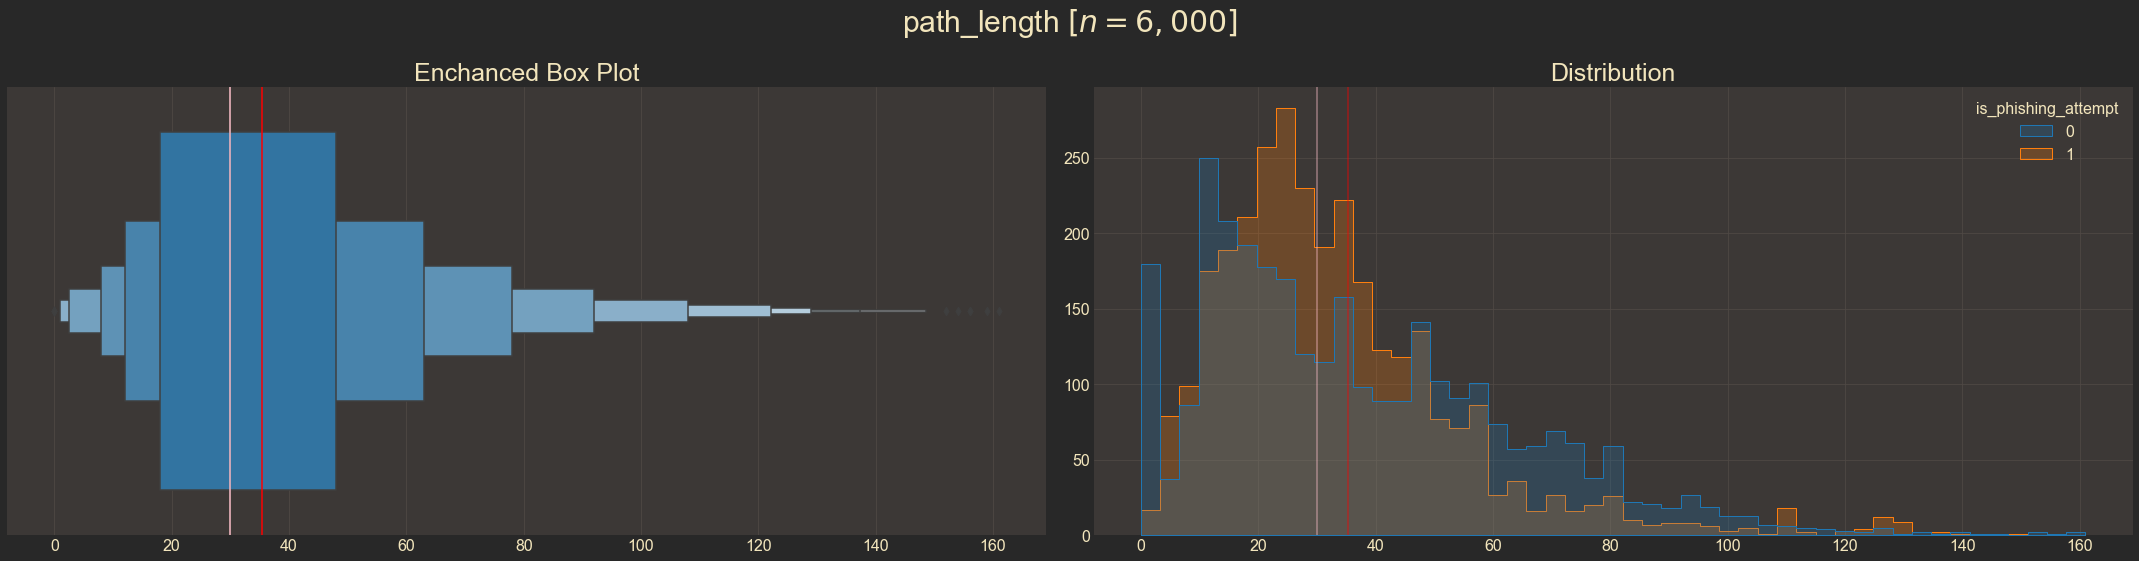

In [14]:
# plot distributions of variables with target hue
ex.plot_univariate(train, 'num_sensitive_words', hue='is_phishing_attempt')
ex.plot_univariate(train, 'num_dash_url', hue='is_phishing_attempt')
ex.plot_univariate(train, 'num_dot_url', hue='is_phishing_attempt')
ex.plot_univariate(train, 'num_numerics', hue='is_phishing_attempt')
ex.plot_univariate(train, 'url_char_length', hue='is_phishing_attempt')
ex.plot_univariate(train, 'path_length', hue='is_phishing_attempt')

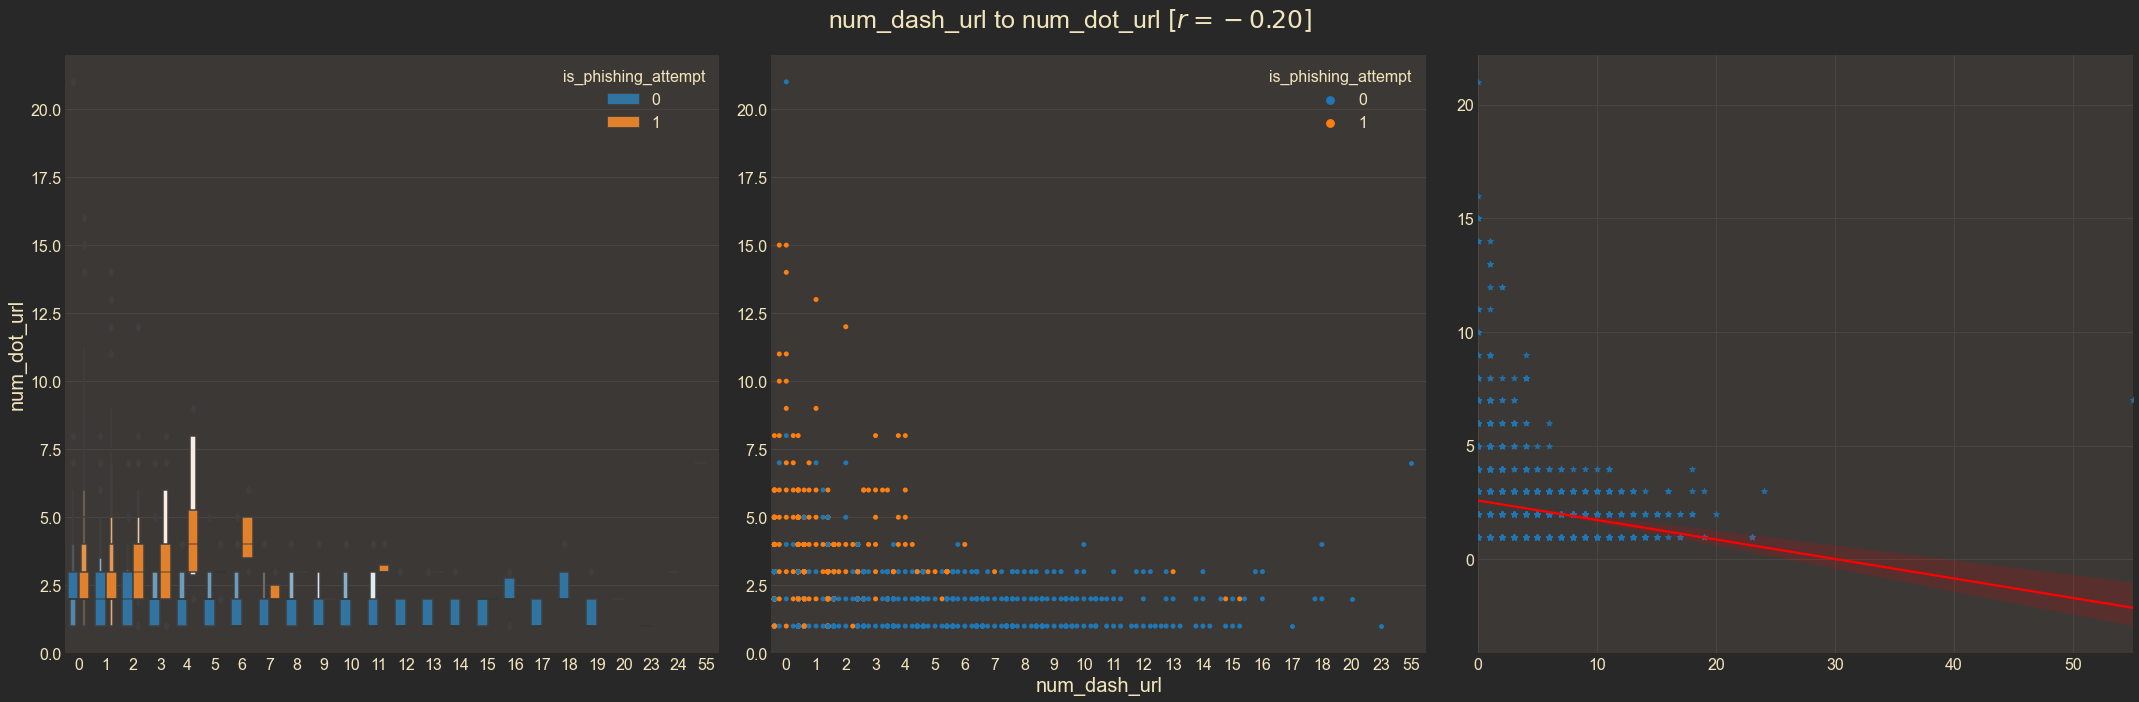

In [15]:
ex.plot_multivariate(train, 'num_dash_url', 'num_dot_url', hue='is_phishing_attempt')

**Statistical Testing**
<br>
To evaluate the independence of theses variables to the target, a $\chi^2$ test will be peformed. 

- H$_0$: `is_phishing_attempt` is independent of the chosen variable.
- H$_a$: `is_phishing_attempt` is not independent of the chosen variable.
- $\alpha$: 0.05

In [16]:
# perform chi^2 test for desired variables
for cat in ['num_sensitive_words', 'num_dash_url', 'num_dot_url']:
    ex.chi_test_lite(train[cat], train.is_phishing_attempt)


  alpha: 0.05
p-value: 8e-98

        Due to p-value 8e-98 being less than significance level 0.05,         may reject the null hypothesis
        that is_phishing_attempt is independent of num_sensitive_words.
        

  alpha: 0.05
p-value: 8e-231

        Due to p-value 8e-231 being less than significance level 0.05,         may reject the null hypothesis
        that is_phishing_attempt is independent of num_dash_url.
        

  alpha: 0.05
p-value: 1e-150

        Due to p-value 1e-150 being less than significance level 0.05,         may reject the null hypothesis
        that is_phishing_attempt is independent of num_dot_url.
        


### Initial Takeaways

- Seemingly strong distinction in hue between `num_dash_url` and `num_dot_url`
    - Fewer dots were more likely to be legitimate
    - Fewer dashes were more likely to be phishing
    - Use clustering to create groups, maybe three, as a created feature
- Distribution of `url_char_length` between both target classes may not line up as hypothesized
- URLs with zero numeric characters were more than twice as likely to be phishing attempts
- The existence of any sensitive words, like "security" or "password", seem much more common in the target's positive class
- All three of the stand out variables rejected the null hypothesis in $\chi^2$ testing for independence from the target

### Cluster Exploration

In the above joint plot, there appears to be a strong division between `num_dash_url` and `num_dot_url` using the target variable as a hue parameter in plotting. Below, the elbow plot method will be used to find the appropriate $k$ clusters to use and then analyzed using ANOVA testing.

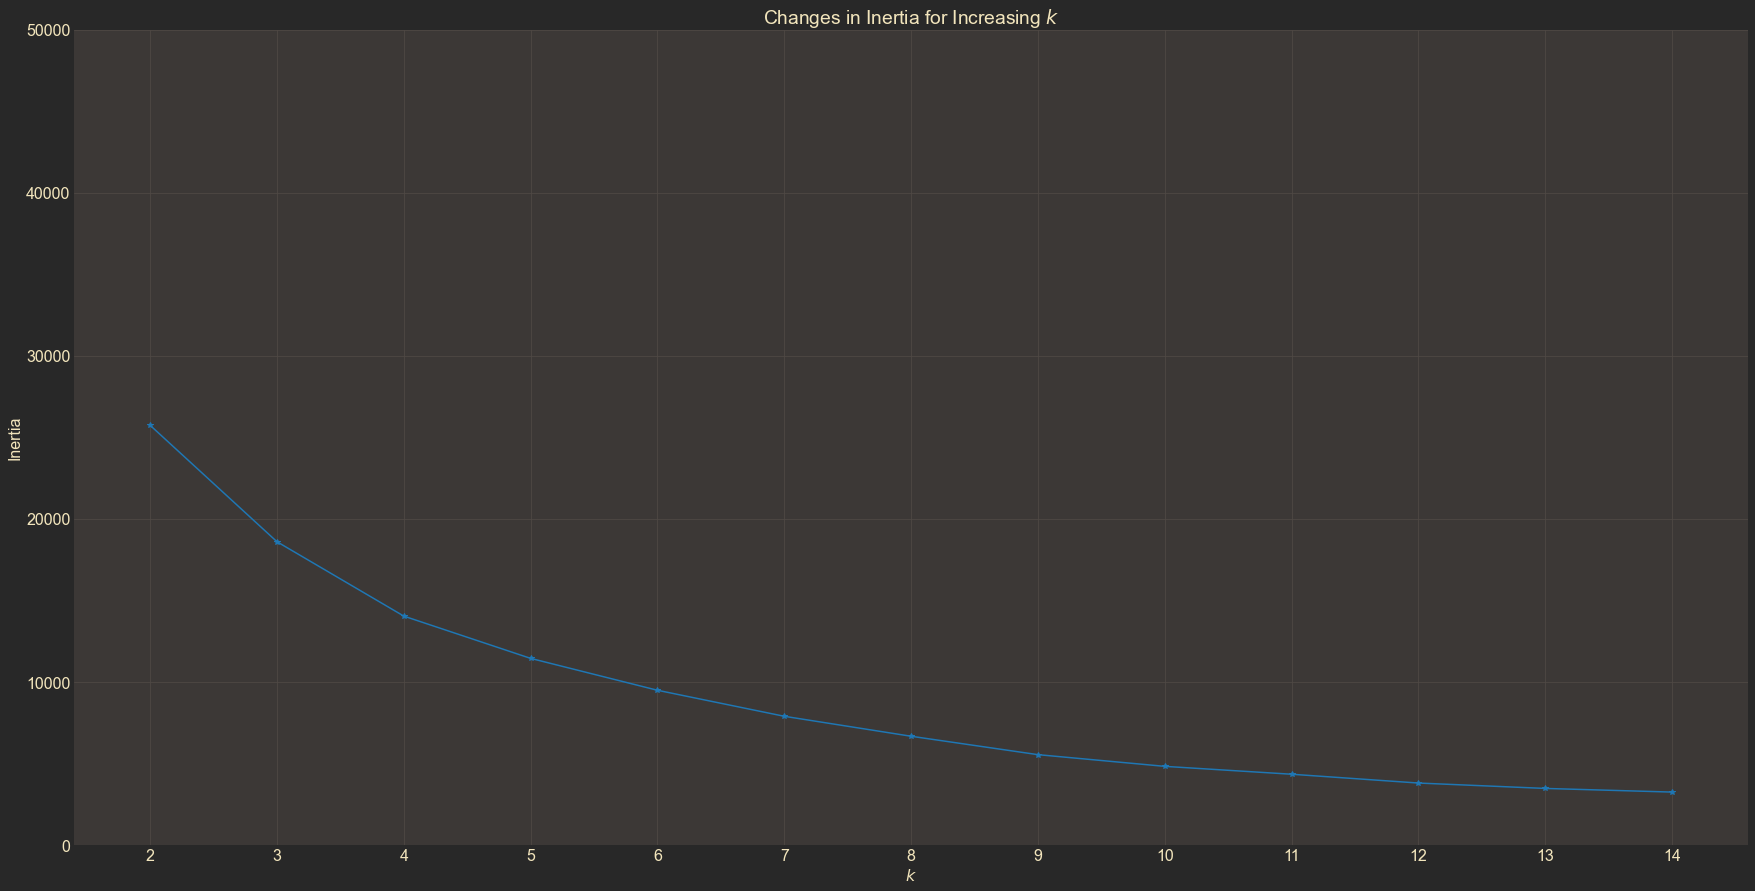

In [17]:
# use elbow plot method to find k optimal clusters
ex.elbow_plot(train, ['num_dash_url', 'num_dot_url'])

In [18]:
# create cluster for exploratory purpose
clusters, centers, _ = ex.explore_clusters(train,
                                ['num_dash_url', 'num_dot_url'], 4)

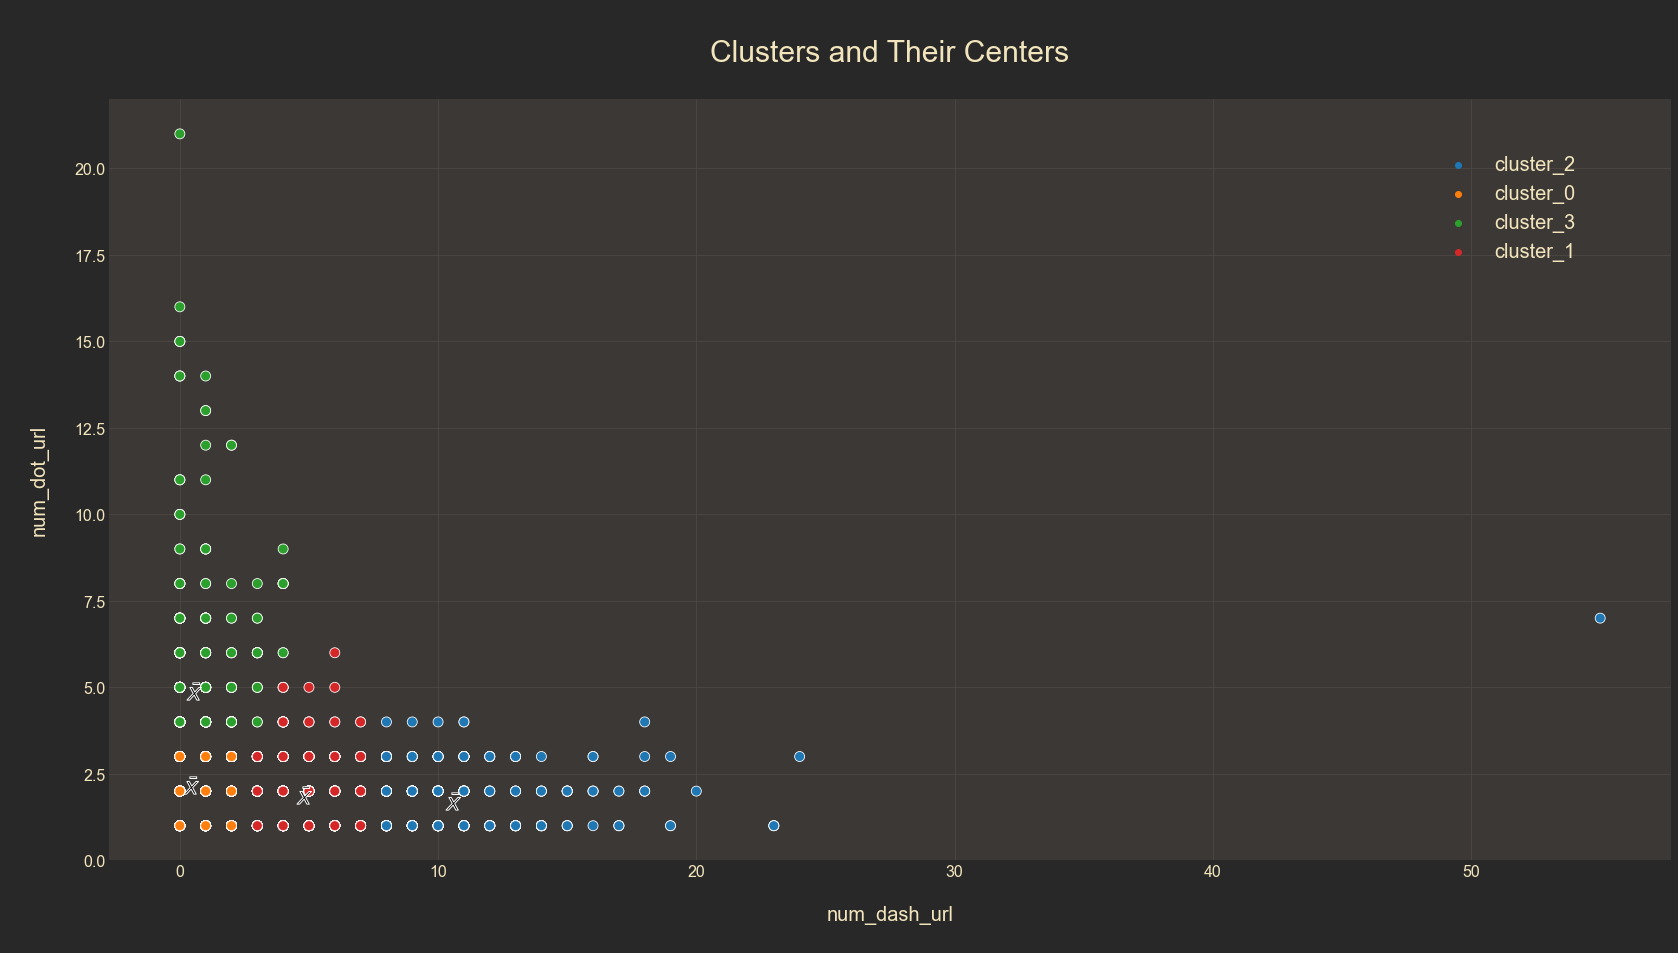

In [19]:
# plot clusters for visual of splits
ex.plot_clusters(clusters, centers, 'num_dash_url', 'num_dot_url')

**Statistical Test**
<br>
To test if there is a difference in the cluster samples from the population, an ANOVA test will be performed in place of multiple T-Tests to reduce likelihood of Type-I errors.

- H$_0$: The four clusters have the same mean as the population.
- H$_a$: The four clusters do not have the same mean as the population.
- $\alpha$: 0.05

In [20]:
# set alpha for testing significance
alpha = 0.05
# create DataFrame of samples for ANOVA testing
samples = pd.concat((clusters, train.is_phishing_attempt), axis=1)
# Perform ANOVA one-way test for null hypotesis
F, p = stats.f_oneway(samples[samples.cluster == 0].is_phishing_attempt,
                      samples[samples.cluster == 1].is_phishing_attempt,
                      samples[samples.cluster == 2].is_phishing_attempt,
                      samples[samples.cluster == 3].is_phishing_attempt)
# print fail or succeed to reject and values returned
if p < alpha:
    state = '✓ May reject'
else:
    state = '𐄂 Fail to reject'
print(f'''
      Stats
+---------------+
|  F-stat: {F:.0f}  |  {state}
| p-value: {p:.2f} |  the null hypothesis.
+---------------+
''')


      Stats
+---------------+
|  F-stat: 517  |  ✓ May reject
| p-value: 0.00 |  the null hypothesis.
+---------------+



**Results**
<br>
It seems the null hypothesis can be strongly rejected, indicating evidence of different means from the population for the clusters. They may have strong use as features in modeling.

In [21]:
# create clusters and encode them on train, validate, test
train, validate, test = ex.create_clusters(train, validate, test,
                        ['num_dash_url', 'num_dot_url'], 'dash_dot', 4)

### 🔥 Exploration Summary
<br>
In the initial exploration phase, there are several key takeaways to document.

- Variables with the strongest correltations to the target are:
    - `num_dot_url`, Pearson $r\approx0.3$
    - `num_sensitive_words`, Pearson $r\approx0.3$
    - `num_dash_url`, Pearson $r\approx-0.4$
- Clustering of `num_dot_url` with `num_dash_url` may provide a usable feature in modeling
    - ANOVA testing of cluster samples rejected null hypothesis that sample means were the same as the population mean
- All three variables above rejected null hypothesis that there was no independence to target in $\chi^2$ test

In [22]:
# split into X, y sets
X_train, y_train, \
X_validate, y_validate, \
X_test, y_test = pp.split_xy(train, validate, test, 'is_phishing_attempt')

## 💠 Modeling

Using classification algorithms from `sklearn`, several models will be created and fitted to the `train` data set before being evaluated using the `validate` data set. `is_phishing_attempt == 1` will be the positive case.

### Feature Selection

`SelectKBest` will be used for feature selection for recommended five and ten features. Features too similar will be removed to maximize available features and prevent placing too much value into certain aspects of fitting.

In [23]:
# use SelectKBest to find best recommended five features
kbest = ex.select_kbest(X_train, y_train, k=5, score_func=f_classif)
print(kbest)

['num_dot_url', 'path_level', 'num_dash_url', 'num_sensitive_words', 'dash_dot_clstr_2']


In [24]:
# remove features too similar
kbest = ex.select_kbest(X_train.drop(columns=['num_dot_url', 'num_dash_url']), y_train, k=5, score_func=f_classif)
print(kbest)

['path_level', 'hostname_length', 'num_sensitive_words', 'dash_dot_clstr_2', 'dash_dot_clstr_3']


In [25]:
kbest_ten = ex.select_kbest(X_train.drop(columns=['num_dot_url', 'num_dash_url']), y_train, k=10, score_func=f_classif)
print(kbest_ten)

['path_level', 'num_dash_hostname', 'has_tilde', 'num_queries', 'domain_in_subdomain', 'domain_in_path', 'hostname_length', 'num_sensitive_words', 'dash_dot_clstr_2', 'dash_dot_clstr_3']


### Baseline

Baseline will be created using the most frequent class will be used as a metric of performance. Due to the innately equal classes in the data, the baseline accuracy will be $50\%$ for either class. It is unlikely that this will be particularly beneficial as the models are unlikely to not out perform this baseline.

In [26]:
# create baseline with most common class
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
class_baseline = dummy.predict(X_train)

In [27]:
# output table of model performance and add predictions to DataFrame
ex.model_report(y_train, class_baseline, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   50.00%          |
|                Precision:    0.00%          |
|                   Recall:    0.00%          |
|            Total Support:     6000          |
|_____________________________________________|


In [28]:
# create DataFrame to hold baseline and predictions
prediction_df = pd.DataFrame(class_baseline)

### ⚙️ Decision Tree 1

To prevent over-fitting, the decision tree models will have a max depth set to prevent indefinite growth. Models will use either the top five or ten recommended features.

In [29]:
# DT max_depth=20

# create and fit tree model
dt20 = DecisionTreeClassifier(max_depth=20, splitter='best', random_state=19)
dt20.fit(X_train[kbest], y_train)

DecisionTreeClassifier(max_depth=20, random_state=19)

In [30]:
# obtain model predictions on train
predictions, _ = m.model_testing(X_train[kbest], y_train, dt20, 'dt20')

In [31]:
# output table of model performance and add predictions to DataFrame
ex.model_report(y_train, predictions, lite=True)
prediction_df['dt20'] = predictions

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   75.37%          |
|                Precision:   74.17%          |
|                   Recall:   77.83%          |
|            Total Support:     6000          |
|_____________________________________________|


### ⚙️ Decision Tree 2

In [32]:
# DT max_depth=10

# create and fit tree model
dt10 = DecisionTreeClassifier(max_depth=10)
dt10.fit(X_train[kbest], y_train)

DecisionTreeClassifier(max_depth=10)

In [33]:
# obtain model predictions on train
predictions, _ = m.model_testing(X_train[kbest], y_train, dt10, 'dt10')

In [34]:
# output table of model performance and add predictions to DataFrame
ex.model_report(y_train, predictions, lite=True)
prediction_df['dt10'] = predictions

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   74.20%          |
|                Precision:   70.58%          |
|                   Recall:   83.00%          |
|            Total Support:     6000          |
|_____________________________________________|


### ⚙️ Decision Tree 3

In [35]:
# DT max_depth=10, kbest_ten features

# create and fit tree model
dt10_ten = DecisionTreeClassifier(max_depth=10)
dt10_ten.fit(X_train[kbest_ten], y_train)

DecisionTreeClassifier(max_depth=10)

In [36]:
# obtain model predictions on train
predictions, _ = m.model_testing(X_train[kbest_ten], y_train, dt10_ten, 'dt10_ten')

In [37]:
# output table of model performance and add predictions to DataFrame
ex.model_report(y_train, predictions, lite=True)
prediction_df['dt10_ten'] = predictions

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   79.32%          |
|                Precision:   75.62%          |
|                   Recall:   86.53%          |
|            Total Support:     6000          |
|_____________________________________________|


### ⚙️ Logistic Regression 1

Logit models will be created again using both top five and ten `SelectKBest` features. Hyperparameters will be left as defaults.

In [38]:
# create and fit logit model with kbest features
logit = LogisticRegression()
logit.fit(X_train[kbest], y_train)

LogisticRegression()

In [39]:
# obtain predictions on train
predictions, _ = m.model_testing(X_train[kbest], y_train, logit, 'logit')

In [40]:
# view model performance and assign predictions to DataFrame
ex.model_report(y_train, predictions, lite=True)
prediction_df['logit'] = predictions

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   71.02%          |
|                Precision:   70.83%          |
|                   Recall:   71.47%          |
|            Total Support:     6000          |
|_____________________________________________|


### ⚙️ Logistic Regression 2

In [41]:
# create and fit logit model with kbest_ten features
logit_ten = LogisticRegression()
logit_ten.fit(X_train[kbest_ten], y_train)

LogisticRegression()

In [42]:
# obtain predictions on train
predictions, _ = m.model_testing(X_train[kbest_ten], y_train, logit_ten, 'logit_ten')

In [43]:
# view model performance and assign predictions to DataFrame
ex.model_report(y_train, predictions, lite=True)
prediction_df['logit_ten'] = predictions

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   74.97%          |
|                Precision:   73.63%          |
|                   Recall:   77.80%          |
|            Total Support:     6000          |
|_____________________________________________|


### ⚙️ Random Forest

Similar to the decision tree models, the random forest models will have its max depth limited. For this model, the best performing individual tree will be used as a initial point for creating a $500$ $n$ forest.

In [44]:
# RF n=500, max_depth=10, kbest_ten features

# create and fit RF model with kbest_ten features
rf10_ten = RandomForestClassifier(n_estimators=500, max_depth=10, bootstrap=True, random_state=19)
rf10_ten.fit(X_train[kbest_ten], y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=19)

In [45]:
# obtain predictions on train
predictions, _ = m.model_testing(X_train[kbest_ten], y_train, rf10_ten, 'rf10_ten')

In [46]:
# view model performance and assign predictions to DataFrame
ex.model_report(y_train, predictions, lite=True)
prediction_df['rf10_ten'] = predictions

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   79.23%          |
|                Precision:   73.23%          |
|                   Recall:   92.17%          |
|            Total Support:     6000          |
|_____________________________________________|


### 🔥 Model Fitting Takeaways

- As expected, all models out performed baseline using "most common" class, which was innately $50\%$ of the data
- Random forest model using $500$ estimators and top ten features was the best in overall accuracy and recall for the positive class
- Decision tree based models out performed logit models, but until evaluation may be over fit

## 💠 Evaluation

To test for over fitting, each model will be tested on the `validate` data set. The primary goal is minimizing the rate of false negatives while still attaining an overall accuracy above $75\%$.

In [47]:
# view performance of dt20 model on validate data set
predictions = ex.validate(X_validate[kbest], y_validate, dt20, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   72.05%          |
|                Precision:   70.47%          |
|                   Recall:   75.90%          |
|            Total Support:     2000          |
|_____________________________________________|


In [48]:
# view performance of dt10 model on validate data set
predictions = ex.validate(X_validate[kbest], y_validate, dt10, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   72.15%          |
|                Precision:   68.63%          |
|                   Recall:   81.60%          |
|            Total Support:     2000          |
|_____________________________________________|


In [49]:
# view performance of dt10_ten model on validate data set
predictions = ex.validate(X_validate[kbest_ten], y_validate, dt10_ten, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   76.75%          |
|                Precision:   73.04%          |
|                   Recall:   84.80%          |
|            Total Support:     2000          |
|_____________________________________________|


In [50]:
# view performance of logit model on validate data set
predictions = ex.validate(X_validate[kbest], y_validate, logit, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   70.15%          |
|                Precision:   69.89%          |
|                   Recall:   70.80%          |
|            Total Support:     2000          |
|_____________________________________________|


In [51]:
# view performance of logit_ten model on validate data set
predictions = ex.validate(X_validate[kbest_ten], y_validate, logit_ten, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   74.15%          |
|                Precision:   72.55%          |
|                   Recall:   77.70%          |
|            Total Support:     2000          |
|_____________________________________________|


In [52]:
# view performance of rf10_ten model on validate data set
predictions = ex.validate(X_validate[kbest_ten], y_validate, rf10_ten, lite=True)

             
 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   78.35%          |
|                Precision:   72.70%          |
|                   Recall:   90.80%          |
|            Total Support:     2000          |
|_____________________________________________|


### 🔥 Evaluation Takeaway

- Decrease in performance was within expected parameters from `train` to `validate` predictions
- Logit model with five features was worst performer in all measured areas
- Random forest with ten features met set goal for performance with a recall nearly $90\%$ and overall accuracy above $78\%$
    - This model will be used in the final `test` data set

### Final Test

Now that evaluation has revealed the best performing model and demonstrated it was not over fit, it's time to perform a final test using the appropriate data set. The goal is maximizing the positive class recall and maintaining an overall accuracy of over $75\%$.

In [53]:
# perform final testing of rf10_ten model
predictions = ex.final_test(X_test[kbest_ten], y_test, rf10_ten)


 _____________________________________________
|            *** Model  Report ***            |
|---------------------------------------------|
|                 Accuracy:   78.20%          |
|       True Positive Rate:   90.50%          |
|      False Positive Rate:   34.10%          |
|       True Negative Rate:   65.90%          |
|      False Negative Rate:    9.50%          |
|                Precision:   72.63%          |
|                   Recall:   90.50%          |
|                 F1-Score:   80.59%          |
|                                             |
|         Positive Support:     1000          |
|         Negative Support:     1000          |
|            Total Support:     2000          |
|_____________________________________________|


<img src='assets/divider.png'>

## 💠 Conclusion

With the data set acquired having been largely already prepared for machine learning, minimal steps needed to be undertaken to fit it to the scope of this project. Using only the composition of the URL in question, all other data was deemed unnecessary and removed. Utilizing three algorithms in classification methodology, 6 models were created to find a best performer in prediction for positive class of `is_phishing_attempt` that minimized the amount of false negatives. With a final performance in recall for the positive class that was nearly $90\%$.

- There is sufficient data and strong evidence to partially corroberate the initial hypotheses
    - Special characters `.` and `-` did play a role in prediction where the inverse relationship created clusters more likely to fall into one class or the other
    - Path level was a algorithm recommended feature by `SelectKBest`
- Random forest model performed best in overall accurazy and specializing in minimizing false negatives
    - To prevent over fitting, max depth was set at ten
    - 500 estimators used in forest size
    - Made use of `kbest_ten` features:
        - `path_level`
        - `num_dash_hostname`
        - `has_tilde`
        - `num_queries`
        - `domain_in_subdomain`
        - `domain_in_path`
        - `hostname_length`
        - `num_sensitive_words`
        - `dash_dot_clstr_1`
        - `dash_dot_clstr_2`

### 🔥 Final Takeaways and Next Steps

Using the predictive power of the final model in conjunction with allow and block lists, the end result provides strong anti-phishing measures with just over $10\%$ of illegitimate links passing through versus $100\%$ with no such measures. There always stands to be room for improvement, however, and with more time it is desirable to expand the scope of this project to include assessment of the web paged linked in the URL. As stated in this project introduction, this would be best accomplished with a dedicated machine to prevent malware exposure to workstations and personal computers. 

In [54]:
end()


































 

































 

































 

































 

































 It’s only after we’ve lost everything that we’re free to do anything.
